In [3]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Vigilar progreso bucles
# -----------------------------------------------------------------------
from tqdm import tqdm

# Gestionar los warnings
# -----------------------------------------------------------------------
import warnings

# modificar el path
# -----------------------------------------------------------------------
import sys
sys.path.append("..")

# importar funciones de soporte
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.soporte_outliers as so
import src.ab_testing_support as ats
import src.association_metrics as am

# encoding
# -----------------------------------------------------------------------
from sklearn.preprocessing import  OneHotEncoder
import category_encoders as ce

# scaling
# -----------------------------------------------------------------------
from sklearn.preprocessing import  RobustScaler, StandardScaler


# evaluar objetos literales
# -----------------------------------------------------------------------
from ast import literal_eval 

# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Introduction - Employee Retention - Preprocessing

## 1.1 Data import

In [4]:
employee_attrition= pd.read_pickle("../data/explored/employee_attrition_explored.pkl")

In [5]:
employee_attrition.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      4410 non-null   int64  
 1   attrition                4410 non-null   object 
 2   businesstravel           4410 non-null   object 
 3   department               4410 non-null   object 
 4   distancefromhome         4410 non-null   int64  
 5   education                4410 non-null   object 
 6   educationfield           4410 non-null   object 
 7   gender                   4410 non-null   object 
 8   joblevel                 4410 non-null   object 
 9   jobrole                  4410 non-null   object 
 10  maritalstatus            4410 non-null   object 
 11  monthlyincome            4410 non-null   int64  
 12  numcompaniesworked       4391 non-null   object 
 13  percentsalaryhike        4410 non-null   object 
 14  stockoptionlevel        

# 2. Preprocessing

## 2.1 Missing values

During the initial exploration notebook, although not frequent, some missing values where found. Let's recheck:

In [6]:
datos_missing = pd.DataFrame(employee_attrition.dtypes, columns = ["tipo_dato"])

datos_missing["missing"] = employee_attrition.isna().sum() 
datos_missing["missing_pct"] = datos_missing["missing"] / employee_attrition.shape[0] * 100

datos_missing = datos_missing[datos_missing["missing_pct"] > 0]
datos_missing

,tipo_dato,missing,missing_pct
numcompaniesworked,object,19,0.430839
totalworkingyears,float64,9,0.204082
environmentsatisfaction,object,25,0.566893
jobsatisfaction,object,20,0.453515
worklifebalance,object,38,0.861678


As we can see, the number of missing values in this features is not significantly impactful, as the category with the maximum number of missing does not achieve a 1% of missing.

In this case, given that missing are not excessively ocurrent, it can suffice with simple strategies like the mean or meadian for numerical datatypes. For categorical features, creating a new category called 'unknown' will not do it, as we would encounter representation problems even for the biggest missing values holder, worklifebalance.

In [7]:
warnings.filterwarnings("ignore") # deactive warnings temporarily

# impute categorical
for categorical in datos_missing[datos_missing["tipo_dato"] == "object"].index:
    mode_value = employee_attrition[categorical].mode().iloc[0]
    employee_attrition[categorical] = employee_attrition[categorical].fillna(mode_value).astype("object")


# impute numerical
employee_attrition["totalworkingyears"].fillna(employee_attrition["totalworkingyears"].median(), inplace=True)

warnings.filterwarnings("default") # reactive warnings

This is done like so here, but it will actually be implemented via sklearn pipelines.

# 2.2 Outliers

To inspect for outliers, the first thing is to perform some visual inspection of univariate outliers via boxplots to to observe which values deviate further than 1.5*IQR from Q1 or Q3.

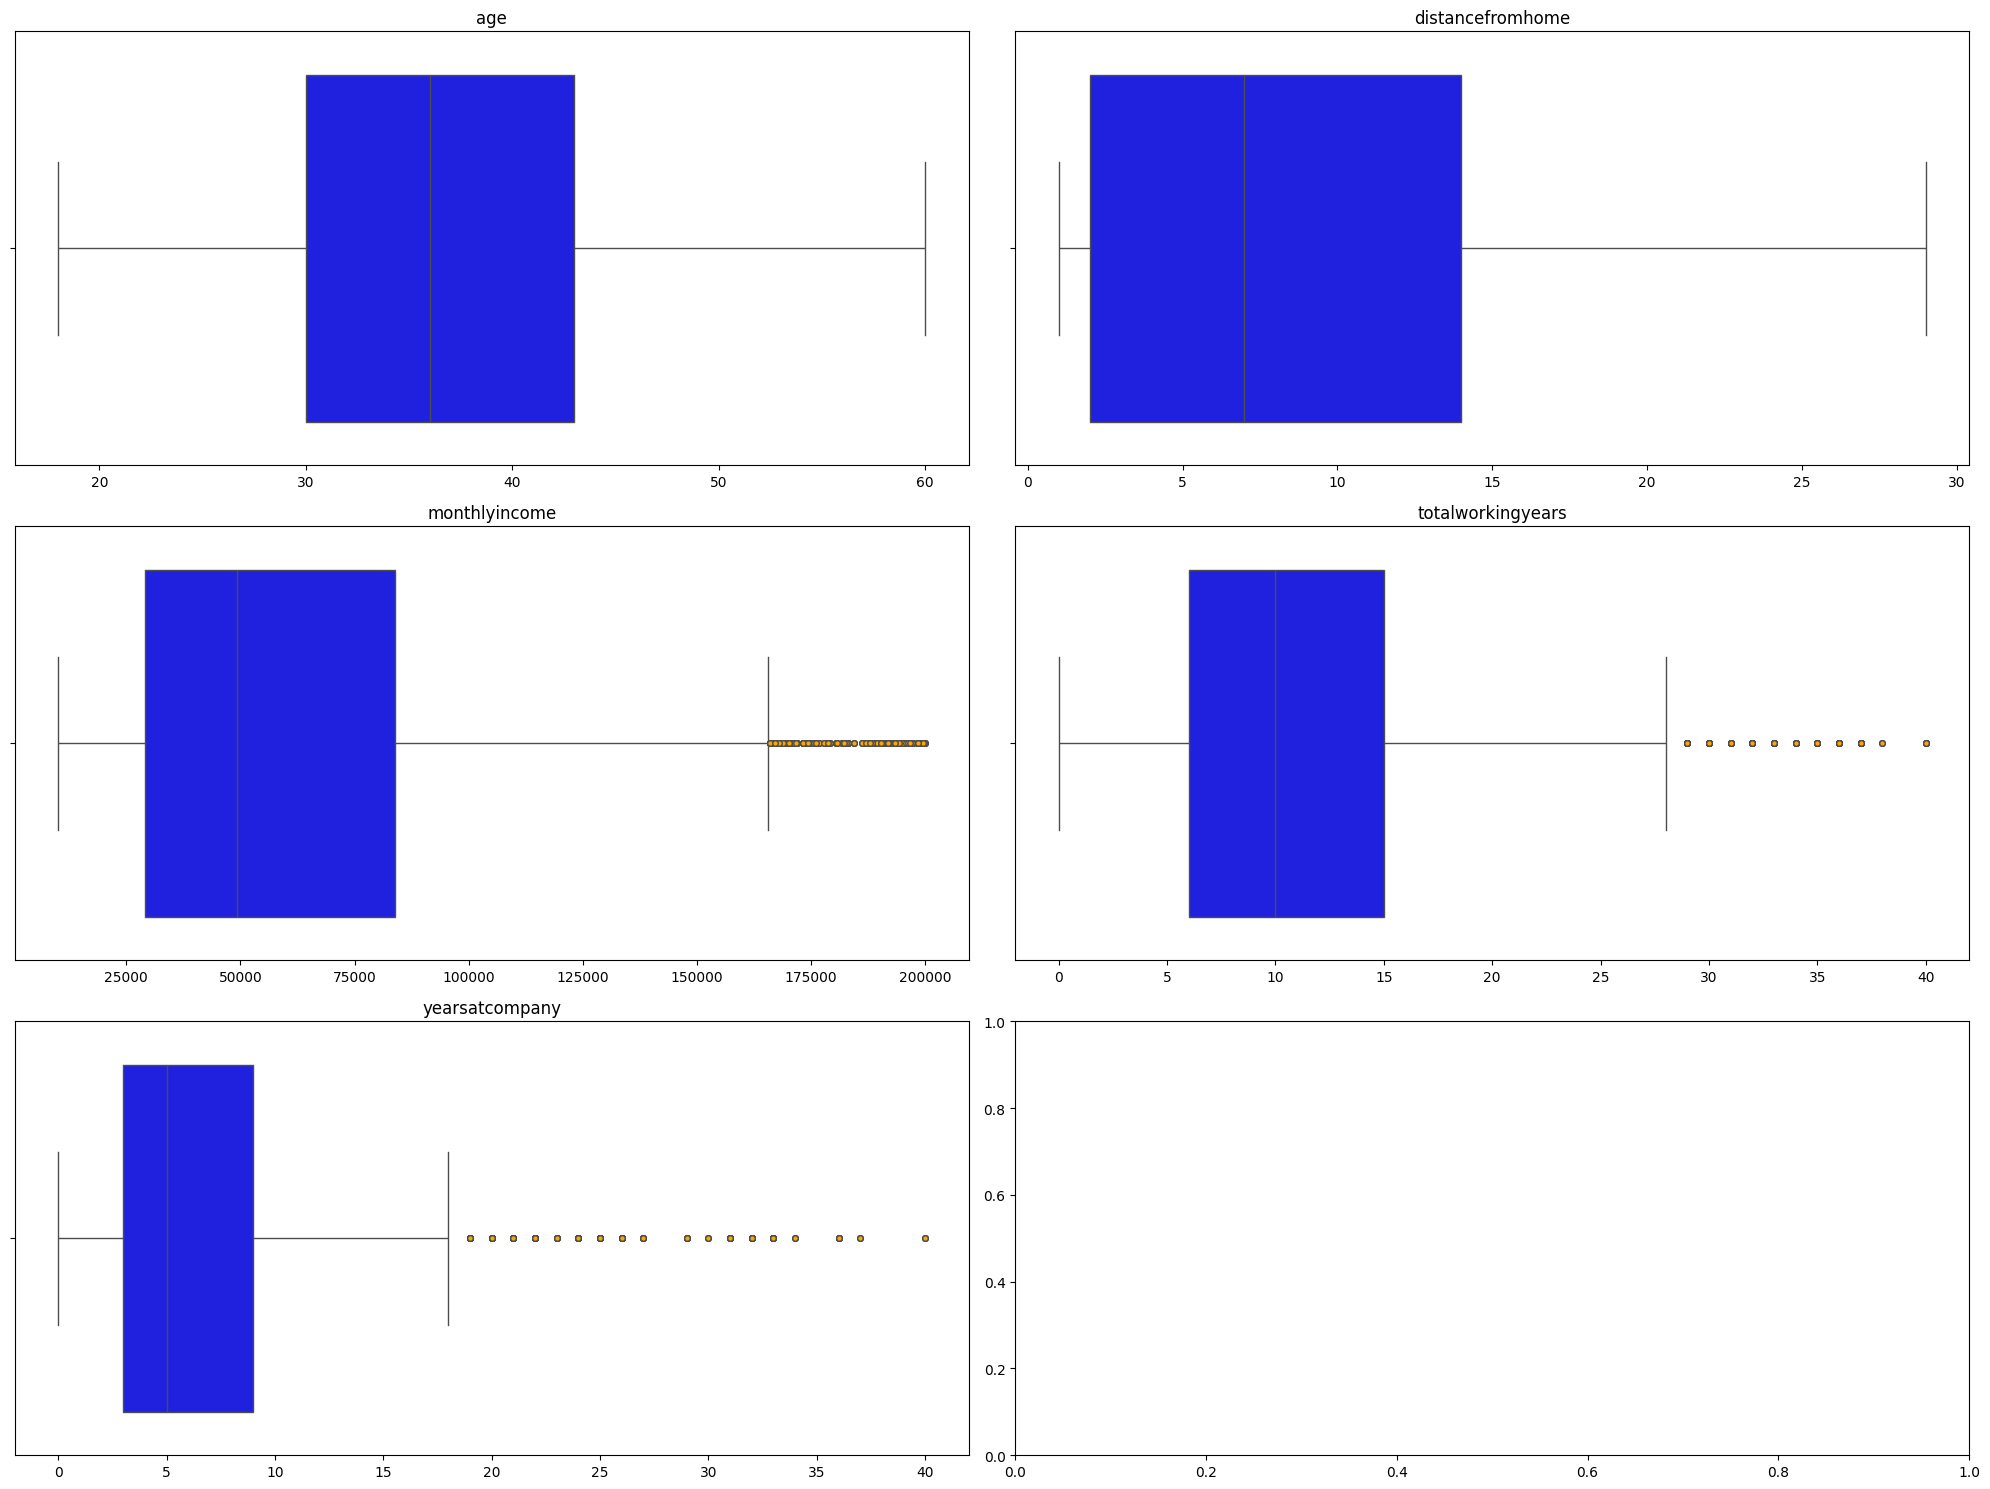

In [8]:
gestor_outliers = so.GestionOutliersUnivariados(employee_attrition)

gestor_outliers.visualizar_outliers_univariados()

From what we can see on the boxplots, there are values that deviate from the the threshold established above. 

In the case of Monthly Income, these supposed outliers are not very spread. Let's remember Monthly Income's distribution was heavily skewed, with no obvious outliers deviating from the distribution. For now, the decision is not to treat these, and to revisit in further iterations.

For totalworkingyears, the case is quite similar. The decrease in absolute frequency of cases as the number of total working years increases shows a very natural and progressive pattern. Thus, it would seem plausible that these values also follow their distribution and are not actually outliers. Besides, although less frequent, it is to be expected to have some very senior employees close to retirement. If anything, these records should be excluded to create a different model.

Finally, speaking of years at company, its pattern is similar to that of totalworkingyears. It did show a more erratic distribution, although it is possible that is does so because of its discrete nature and relatively low number of unique values. The conclusion, once again for now, is to leave them as is, because treating outliers is a delicate subject, as they are not black or white identified as such. However, they will be kept in mind for further iteration.

### 2.2.2 Bivariate outliers

To check for "erroneous" outliers, let's see that no nonsense values are present by visually inspecting pairwise interactions via pairplots.

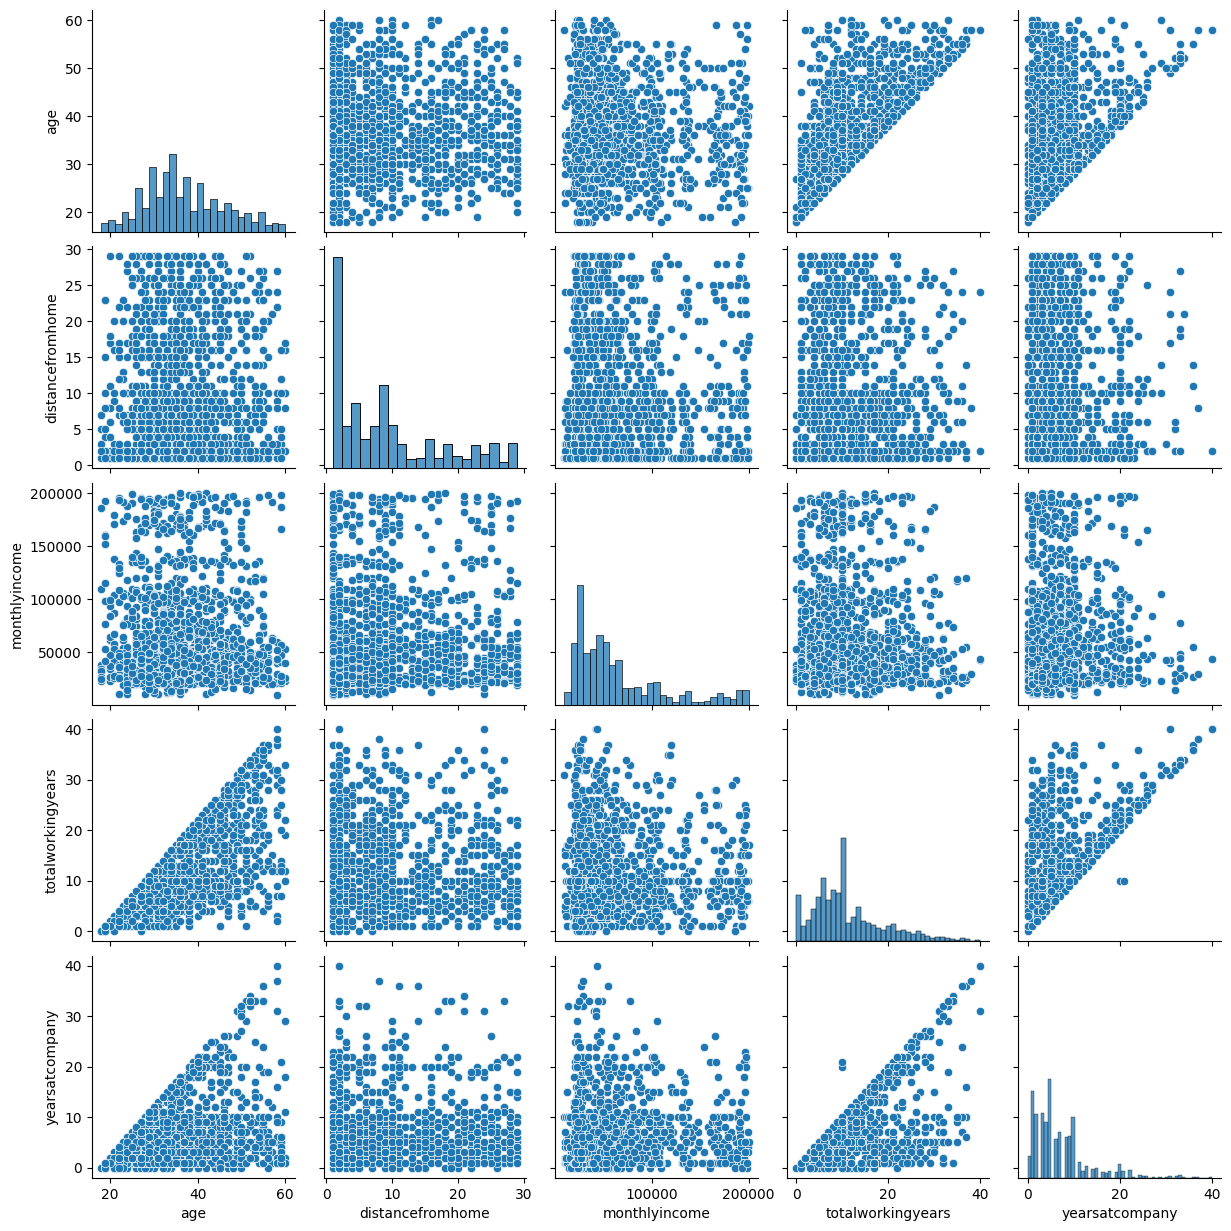

In [9]:
sns.pairplot(employee_attrition.select_dtypes(np.number))

Everything seems normal, except for a small groups of employees that display more years at company than they have total working years for. These are considered abnormal outliers or errors, and are treated as missing.

In [10]:
mask = employee_attrition["yearsatcompany"] > employee_attrition["totalworkingyears"]
employee_attrition.loc[mask,["yearsatcompany","totalworkingyears"]] = np.nan

# 3. Encoding

To find suitable encodings it is necessary to take into consideration the relationship a categorical variable holds with respect to the target and its cardinality. Features with 2 or 3 categories are better off encoded as one-hot. Highly cardinal features are better encoded with target encoding as they do not increase dimensionality and helps the model infer the relationship with the predictor, although interpretation gets really difficult.

Inspecting association with the target can serve the purpose of finding significant features. However, albeit useful for simple models like linear or logistic regression, it can be misleading as it leaves out interactions with other features. Post-hocs, on the other hand, can help find non-significant differences among categories to simplify them to clear noise in case of over-fitting or poor explainability.

Therefore, a first approach will be to just base encoding in categorical cardinality, to use it as a baseline for further refinements looking for either:
- Better performance
- Less overfitting 
- Improved interpretability

Exploring how onehot encoding would look:

In [11]:
feautures_upto_three_categories = employee_attrition.loc[:,(employee_attrition.nunique() <= 3)]

X = feautures_upto_three_categories.drop(columns="attrition")
y = employee_attrition["attrition"].replace({"Yes": 1, "No": 0})

# drop first to avoid multicolinearity
ohe_encoder = OneHotEncoder(sparse_output=False, drop="first")
ohe_encoded_df = pd.DataFrame(ohe_encoder.fit_transform(X,y),columns=ohe_encoder.get_feature_names_out())
ohe_encoded_df.sample(5)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_27344\854369318.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = employee_attrition["attrition"].replace({"Yes": 1, "No": 0})


,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,gender_Male,maritalstatus_Married,maritalstatus_Single,performancerating_4
3622,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
723,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
241,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4313,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3643,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


Exploring how target encoding would look:

In [12]:
feautures_many_categories = employee_attrition.loc[:,(employee_attrition.nunique() > 3)]

X = feautures_many_categories
y = employee_attrition["attrition"].replace({"Yes": 1, "No": 0})

target_encoder = ce.TargetEncoder()
target_encoded_df = target_encoder.fit_transform(X,y)
target_encoded_df.sample(5)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_27344\2109047586.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = employee_attrition["attrition"].replace({"Yes": 1, "No": 0})


,age,distancefromhome,education,educationfield,joblevel,jobrole,monthlyincome,numcompaniesworked,percentsalaryhike,stockoptionlevel,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearssincelastpromotion,yearswithcurrmanager,environmentsatisfaction,jobsatisfaction,worklifebalance,jobinvolvement
2706,34,15,0.187943,0.157233,0.177903,0.181507,84630,0.109589,0.162679,0.167987,8.0,0.171846,4.0,0.137255,0.133803,0.149533,0.229070,0.142328,0.216867
74,54,1,0.155779,0.166667,0.177903,0.181507,29330,0.101266,0.151515,0.177215,20.0,0.171846,4.0,0.189329,0.133803,0.134183,0.165533,0.167812,0.153226
2875,43,6,0.187943,0.161638,0.154696,0.145038,20280,0.120482,0.163636,0.151007,7.0,0.171846,5.0,0.169811,0.145349,0.134183,0.113194,0.178414,0.160000
2982,41,29,0.152941,0.166667,0.154696,0.162162,23790,0.188332,0.151515,0.167987,22.0,0.061538,22.0,0.189329,0.112245,0.134183,0.164286,0.142328,0.153226
3401,47,18,0.155779,0.161638,0.177903,0.181507,55820,0.188332,0.128205,0.167987,9.0,0.175153,9.0,0.189329,0.143519,0.134183,0.113194,0.142328,0.153226


Putting them together:

In [13]:
employee_attrition_encoded_X = pd.concat([ohe_encoded_df, target_encoded_df], axis=1)
employee_attrition_encoded_X.sample(5)

,businesstravel_Travel_Frequently,businesstravel_Travel_Rarely,department_Research & Development,department_Sales,gender_Male,maritalstatus_Married,maritalstatus_Single,performancerating_4,age,distancefromhome,...,stockoptionlevel,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearssincelastpromotion,yearswithcurrmanager,environmentsatisfaction,jobsatisfaction,worklifebalance,jobinvolvement
422,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,36,2,...,0.177215,8.0,0.175153,6.0,0.189329,0.144737,0.149533,0.113194,0.142328,0.160000
3893,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,37,13,...,0.151007,6.0,0.130081,6.0,0.137255,0.133803,0.138909,0.113194,0.167812,0.153226
189,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,35,22,...,0.167987,15.0,0.171846,11.0,0.187487,0.093750,0.149533,0.165533,0.142328,0.160000
1064,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,46,1,...,0.167987,12.0,0.171846,9.0,0.081967,0.143519,0.134183,0.113194,0.167812,0.153226
1001,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,30,2,...,0.151007,10.0,0.175153,7.0,0.137255,0.143519,0.138909,0.165533,0.142328,0.153226


Inspecting the results:

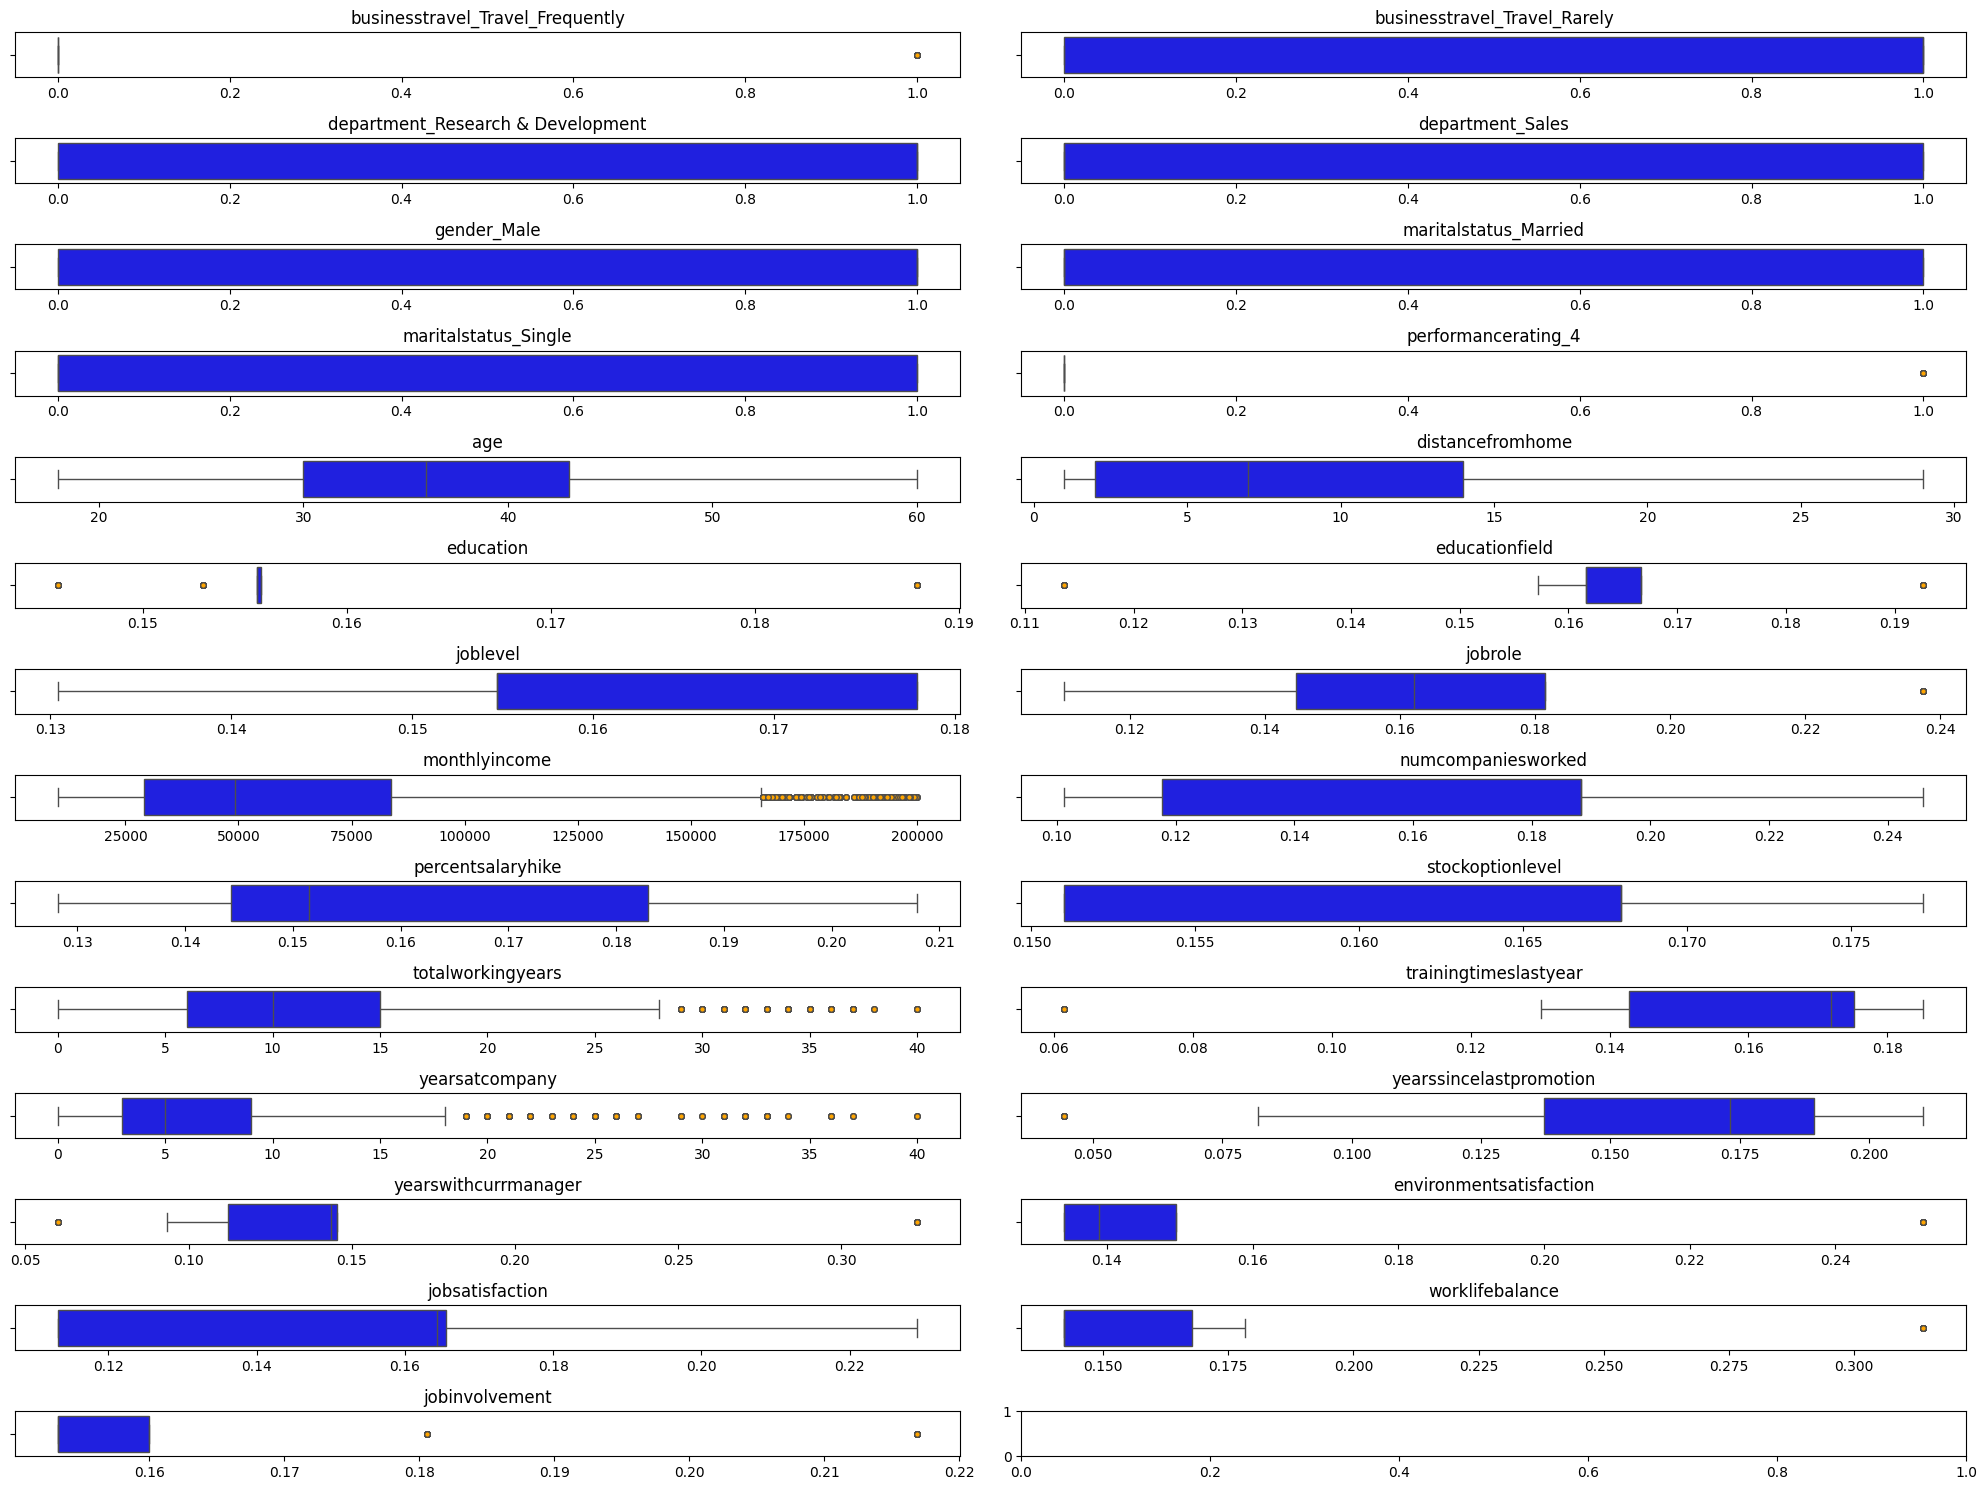

In [14]:
gestor_outliers = so.GestionOutliersUnivariados(employee_attrition_encoded_X)

gestor_outliers.visualizar_outliers_univariados()

# 4. Scaling

The first approach for modelling will be based on non-linear tree based models, where scaling has no impact.

On later steps, it would be interesting to see if it is possible to approximate the results of those models to a logistic regression. In that case, not scaling the one-hot encoded features or target features is best. One-hot encoded features just have 0 and 1 values, while target encoded features have been encoded to distribute around the mean of the target. 

Nuerical features, however, should be scaled, for which Robust Scaler is suggested, to preserve extreme values (not yet considered outliers) and values that display high mean values with respect to the target, is considered optimal.

To observe what the changes would look like:

In [17]:
scaler = StandardScaler()

numerical_features = ["yearsatcompany", "monthlyincome", "age", "distancefromhome", "totalworkingyears"]

employee_attrition_numerical_scaled = pd.DataFrame(scaler.fit_transform(employee_attrition[numerical_features]), columns=scaler.get_feature_names_out())
employee_attrition_numerical_scaled.sample(5)

,yearsatcompany,monthlyincome,age,distancefromhome,totalworkingyears
530,0.163090,0.202719,-0.977174,-1.010909,-0.164354
2977,2.124171,-0.753647,0.555852,-0.887515,1.507602
2419,-0.490604,-0.884109,1.979376,1.703764,-0.421578
870,-0.654027,-0.886871,-0.101159,1.456975,-0.292966
2910,0.489937,-0.925967,-0.210661,1.210187,-0.164354


Let's inspect the results in case there is something odd:

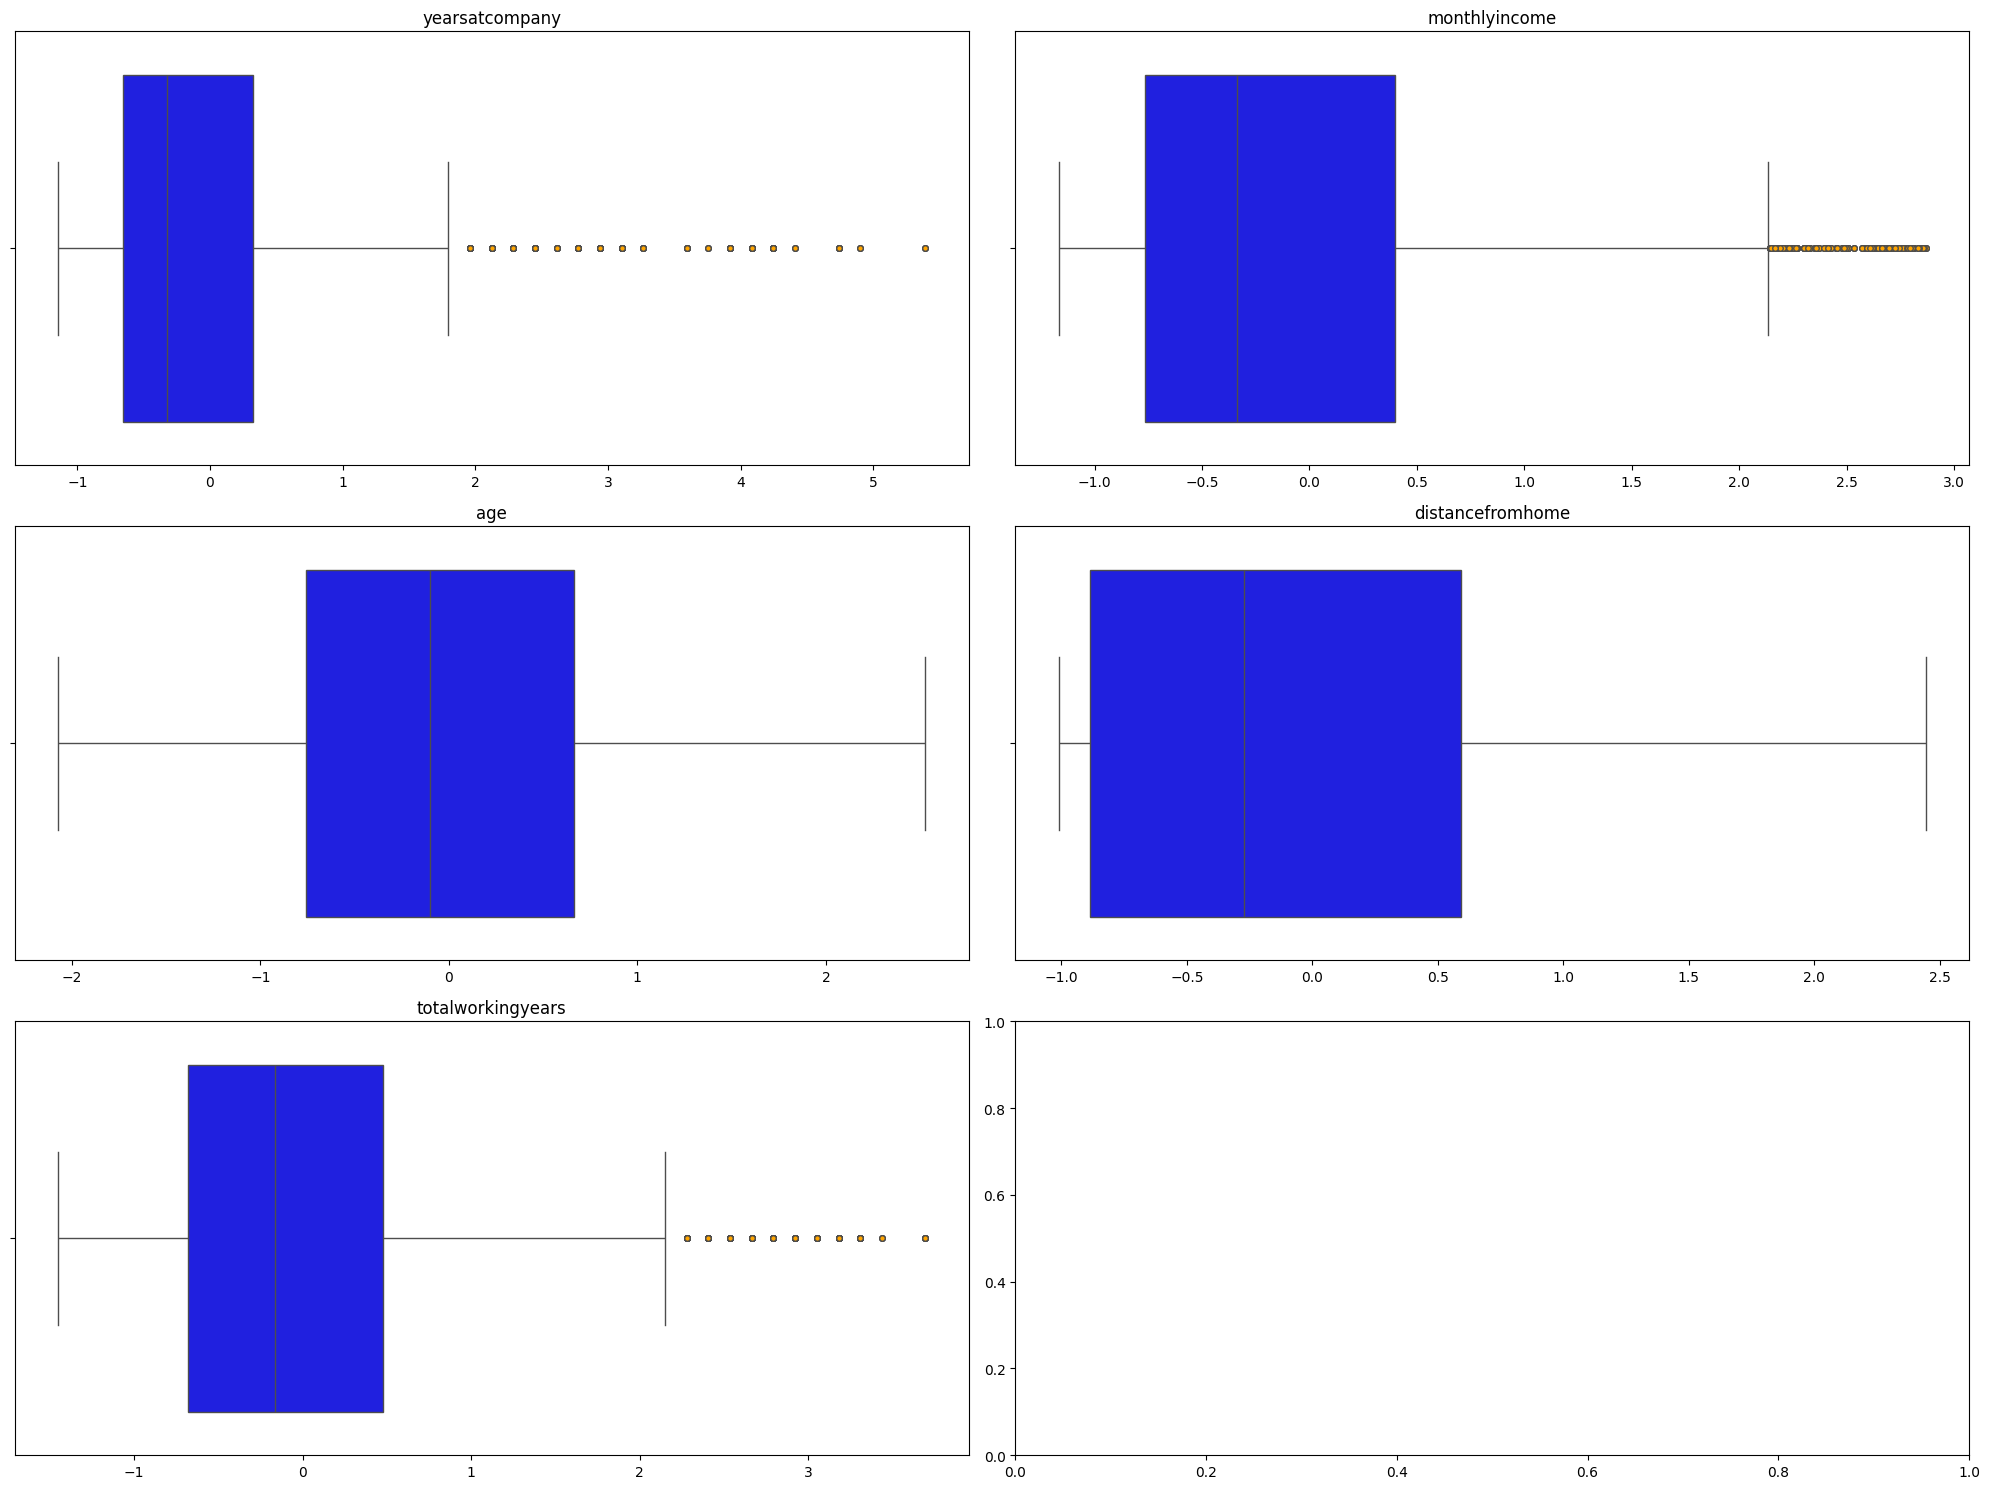

In [18]:
gestor_outliers = so.GestionOutliersUnivariados(employee_attrition_numerical_scaled)

gestor_outliers.visualizar_outliers_univariados()

We can see that the features are now centered around the same values and have similar ranges for their 1.5*IQR±Q1_3.

# 5. Over/undersampling - SMOTE

For model evaluations, SMOTE will not be used. That is because it can complicate pipelines, introduce overhead and also make comparisons artificial. For a final and chosen model, SMOTE will be used to studied via cross-validation to compare whether it helps achieve better results in terms of AUC-PR than not using it.